In [1]:
import fix_sys_path
from plasma_classes import *
from plasma_utils import *
from matplotlib import pyplot as plt
from matplotlib import animation
from tqdm import tqdm

../source_code\plasma_utils.py:32: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(f8[:] (f8[:],f8[:],f8[:],f8[:] ))
../source_code\plasma_utils.py:32: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "TDMAsolver" failed type inference due to: No implementation of function Function(<class 'map'>) found for signature:
 
 >>> map(Function(<built-in function array>), UniTuple(array(float64, 1d, A) x 4))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'ol_map': File: numba\cpython\builtins.py: Line 725.
    With argument(s): '(Function(<built-in function array>), UniTuple(

In [2]:
root = os.getcwd()


In [3]:
exps = os.listdir(os.path.join(root, "logs"))
exps = list(sorted(exps))
exps

['Te10.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_31_05_2023_21_45_53',
 'Te13.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_31_05_2023_21_46_01',
 'Te15.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_31_05_2023_21_46_06',
 'Te17.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_31_05_2023_21_45_25',
 'Te20.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_02_06_2023_00_02_05',
 'Te23.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_31_05_2023_21_46_15',
 'Te27.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_02_06_2023_00_02_16',
 'Te30.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_02_06_2023_00_02_24',
 'Te35.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_02_06_2023_00_02_31',
 'Te40.0Nx2000_Np20000_h5e-06_tau2.5e-13_n5000000_02_06_2023_00_02_46']

In [4]:
#exps = ['Te20.0Nx1000_Np20000_h1e-05_tau5e-13_n1000000_27_05_2023_22_47_51']

In [5]:
len(exps)

10

In [6]:
iters = {
    10 : 30000,
    13: 30000,
    15: 30000,
    17: 30000,
    20: 30000,
    23: 30000,
    25: 30000,
    27: 30000,
    30: 30000,
    35: 30000,
    40: 30000,

}

In [7]:
energy_arr = []
temp_arr = []
sigma_arr = []
for path in tqdm(exps):
    temp = float(path[2:4])
    temp_arr.append(temp)
    logpath = os.path.join(root, "logs",  path)
    params_file = os.path.join(logpath, "params.bin")
    with open(params_file, "rb") as f:
        params = pickle.load(f)
    time_step = params["periods"]["saving"]
    h = params["geometry"]["L"]/params["numerical"]["N_x"]
    tau = params["numerical"]["tau"]
    time_step = params["periods"]["saving"]

    secondary_counts = 0
    energies = []
    for i, particles in loop_over_states(os.path.join(logpath, "secondary_electrons.bin"), modes=["particles"]):
        if i > iters[temp]*time_step:
            secondary_counts += particles.n_macro
    absorbed_counts = 0
    for i, particles in loop_over_states(os.path.join(logpath, "absorbed_electrons.bin"), modes=["particles"]):
        if i > iters[temp]*time_step:
            absorbed_counts += particles.n_macro
            energy = calc_kinetic_energy(particles, h, tau)
            energies.append(energy/particles.n_macro/particles.q/particles.concentration)
    sigma_arr.append(secondary_counts/absorbed_counts)
    energy_arr.append(np.mean(np.array(energies)))
    

100%|██████████| 10/10 [01:26<00:00,  8.67s/it]


In [34]:
energy_arr = -np.array(energy_arr)

In [35]:
sigma_arr = np.array(sigma_arr)

In [8]:
sigma_arr

[0.5880096891400888,
 0.6832647462277092,
 0.7382496809868141,
 0.8115942028985508,
 0.8824587455294585,
 0.949852613415774,
 0.9924430726078599,
 1.0083669453050408,
 1.024991816064899,
 1.0397420134170279]

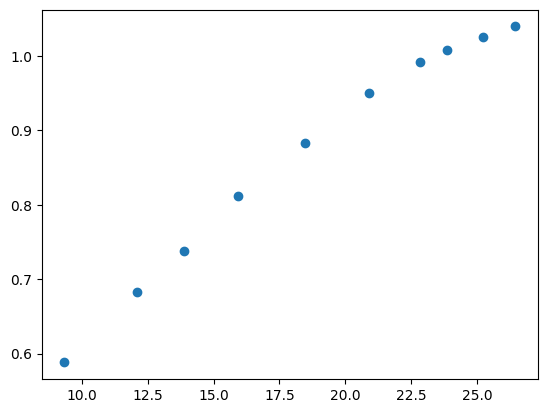

In [36]:
plt.scatter(energy_arr, sigma_arr)

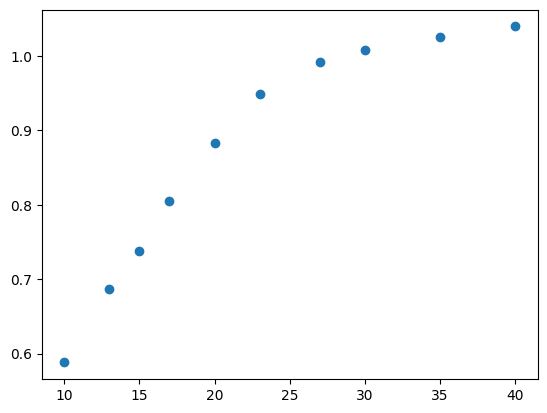

In [12]:
plt.scatter(temp_arr, sigma_arr)

In [13]:
import numpy as np
from sklearn.linear_model import LinearRegression


# Define the logarithmic transformation function
def log_transform(E, sigma):
    return np.log(E), np.log(sigma)

# Set the constant value E1
E1 = 18.3

# Define your set of points in E-sigma space
E_data = energy_arr/E1
sigma_data = sigma_arr

# Apply logarithmic transformation to the data
E_data, sigma_data = log_transform(E_data, sigma_data)

# Perform linear regression to estimate the value of alpha
regressor = LinearRegression()
regressor.fit(E_data.reshape(-1, 1), sigma_data)
estimated_alpha = regressor.coef_[0]

# Print the estimated value of alpha
print("Estimated alpha:", estimated_alpha)


Estimated alpha: 0.563239213784654


In [13]:
sigma_arr

array([0.58800969, 0.68634009, 0.73824968, 0.80487322, 0.92321875,
       0.94876728])

In [27]:
mass_dct = {}
energy_dct = {}
impulse_dct = {}

for path in tqdm(exps):
    temp = float(path[2:4])
    logpath = os.path.join(root, "logs",  path)
    params_file = os.path.join(logpath, "params.bin")
    with open(params_file, "rb") as f:
        params = pickle.load(f)
    time_step = params["periods"]["saving"]
    h = params["geometry"]["L"]/params["numerical"]["N_x"]
    tau = params["numerical"]["tau"]
    start = iters[temp]*time_step
    for kind in ["absorbed_electrons", "absorbed_ions", "secondary_electrons"]:
        if kind not in energy_dct:
            energy_dct[kind] = []
        if kind not in impulse_dct:
            impulse_dct[kind] = []
        if kind not in mass_dct:
            mass_dct[kind] = []
        energy = 0
        impulse = 0
        mass = 0

        for i, particles in loop_over_states(os.path.join(logpath, kind + ".bin"), modes=["particles"]):
            if i > start:
                mass += particles.n_macro*particles.m*particles.concentration
                energy += calc_kinetic_energy(particles, h, tau)
                impulse += calc_impulse(particles, h, tau)
        energy = energy/(i-start)/tau
        impulse = impulse/(i-start)/tau
        mass = mass/(i-start)/tau
        energy_dct[kind].append(energy)
        impulse_dct[kind].append(impulse)
        mass_dct[kind].append(mass)

    

100%|██████████| 10/10 [02:07<00:00, 12.71s/it]


In [22]:
phi_lst = []
for path in exps:
    temp = float(path[2:4])
    phi_per_exp = []
    logpath = os.path.join(root, "logs",  path)
    with open(params_file, "rb") as f:
        params = pickle.load(f)
    n_range = params["geometry"]["neutral_range"]
    for i, nodes, particles, _ in loop_over_states(os.path.join(logpath, "system_states.bin")):
        if i/100 > iters[temp]:
            phi = np.mean(nodes.phi[n_range[0] : n_range[1]])
            phi_per_exp.append(phi)

    phi_lst.append(np.mean(np.array(phi_per_exp)))

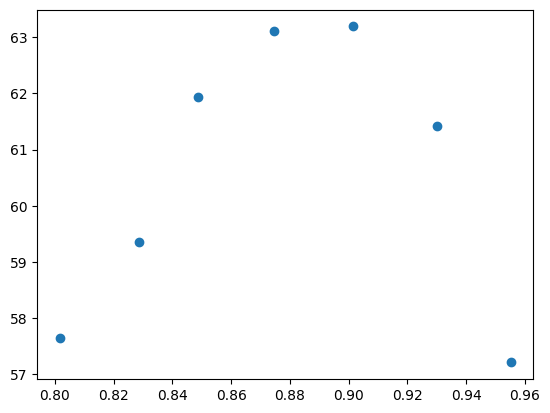

In [23]:
plt.scatter(sigma_arr, phi_lst)

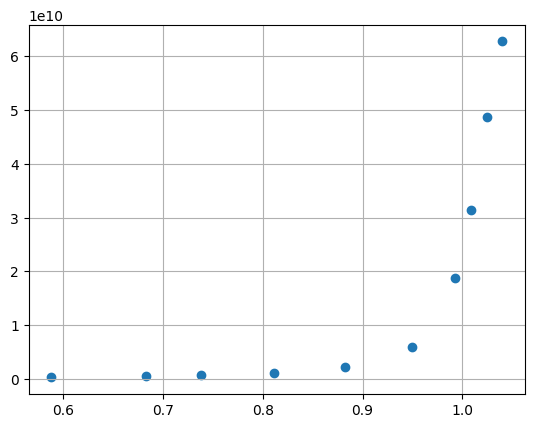

In [28]:
plt.scatter(sigma_arr, energy_dct["absorbed_electrons"])
plt.grid()

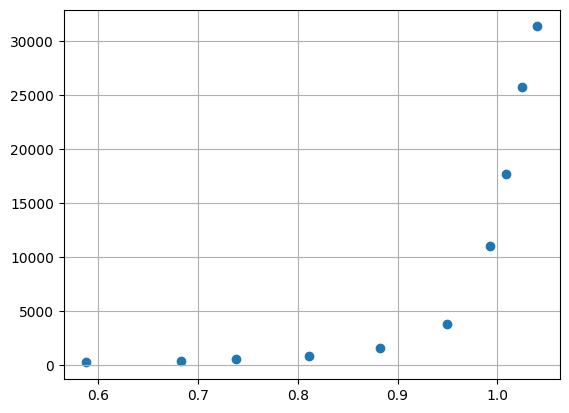

In [29]:
plt.scatter(sigma_arr, impulse_dct["absorbed_electrons"])
plt.grid()


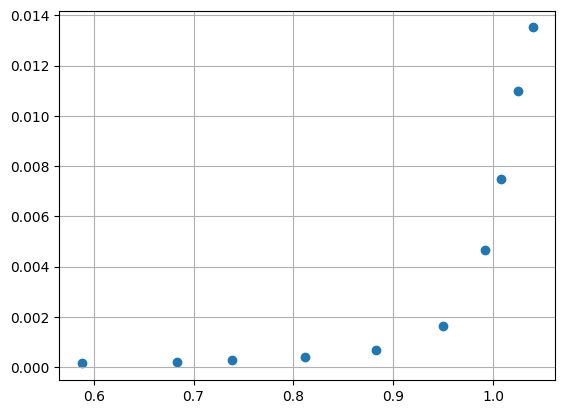

In [30]:
plt.scatter(sigma_arr, mass_dct["absorbed_electrons"])
plt.grid()


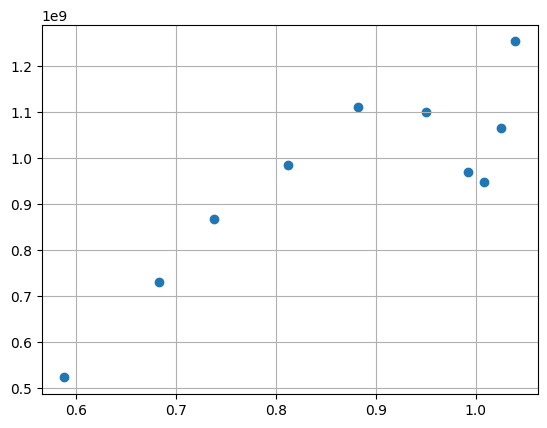

In [31]:
plt.scatter(sigma_arr, energy_dct["absorbed_ions"])
plt.grid()


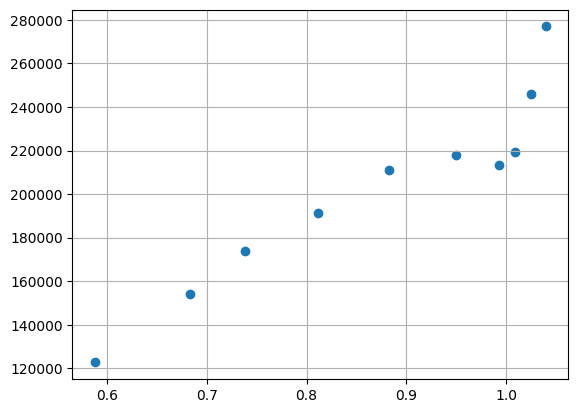

In [32]:
plt.scatter(sigma_arr, impulse_dct["absorbed_ions"])
plt.grid()


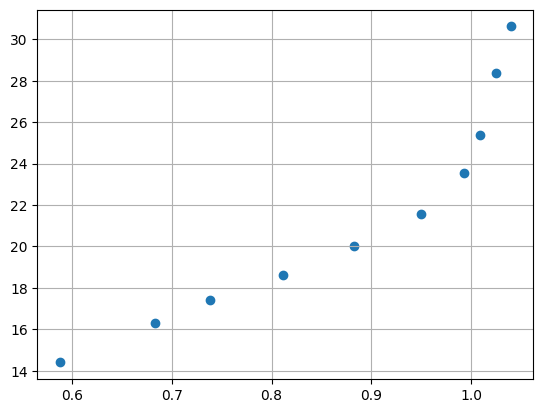

In [33]:
plt.scatter(sigma_arr, mass_dct["absorbed_ions"])
plt.grid()


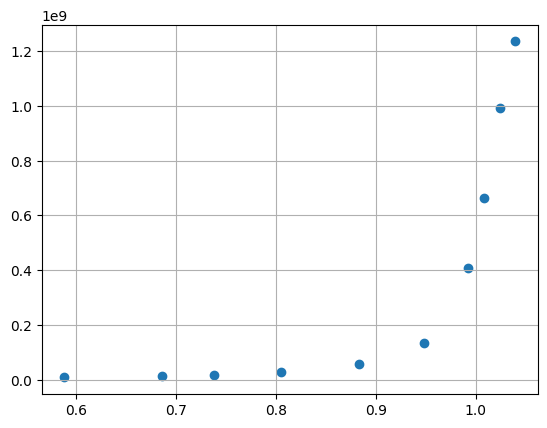

In [22]:
plt.scatter(sigma_arr, energy_dct["secondary_electrons"])
plt.grid()


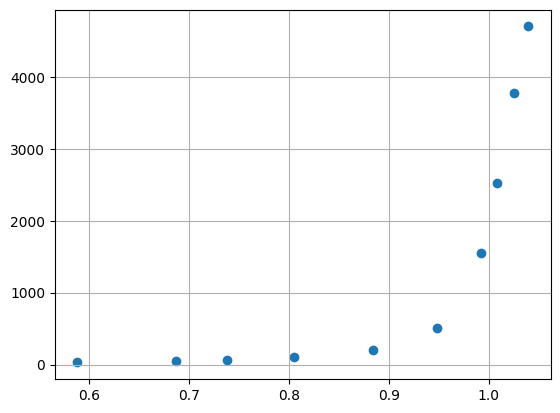

In [23]:
plt.scatter(sigma_arr, impulse_dct["secondary_electrons"])
plt.grid()


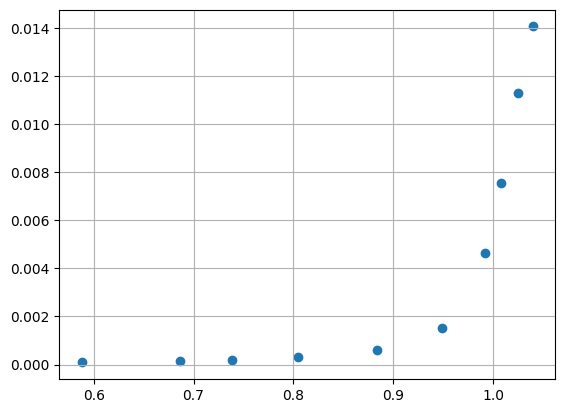

In [24]:
plt.scatter(sigma_arr, mass_dct["secondary_electrons"])
plt.grid()
